# Homework 04 - Francesco Ortu

In [1]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyro.infer.mcmc import MCMC, HMC, NUTS

## Ex 1

----
Let $\theta_1$ and $\theta_2$ be real valued parameters in $[0,1]$ and consider the generative model
\begin{align*}
\theta_1 &\sim \theta_1\text{-prior}\\
\theta_2 &\sim \theta_2\text{-prior}\\
\hat{y} &= \frac{\theta_1+x^2}{\theta_2\cdot x}\\
y &\sim \mathcal{N} (\hat{y}, 1)
\end{align*}

a. Use pyro to implement the model as a function `model(theta1_prior, theta2_prior, x, obs)`, where `theta1_prior` and `theta2_prior` are pyro.distributions objects, `x` and `obs` are torch tensors, and draws from the normal distribution are conditioned on `obs`.

b. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$ (e.g. suitably rescaled Normal or Beta distributions)  and use HMC or NUTS algorithm to find their posterior distributions given the observations

\begin{align*}
x&=(47,87,20,16,38,5)\\
y&=(58.76, 108.75,  25.03,  20.03,  47.51,  6.37).
\end{align*}


c. Discuss how different prior distributions lead to different estimates of $\theta_1$ and $\theta_2$. Comment on the convergence checks and plot the posterior distributions. 

-----

In [2]:
# class model():
#     def __init__(self,theta1_prior, theta2_prior):
#         self.theta1_prior = theta1_prior
#         self.theta2_prior = theta2_prior
        
#     def __call__(self, x,obs):
#         theta_1 = pyro.sample('theta_1', self.theta1_prior)
#         theta_2 = pyro.sample('theta_2', self.theta2_prior)
#         y_hat = ( theta_1 + x**2 ) / ( theta_2 * x )
#         y = pyro.sample('obs', dist.Normal(y_hat, 1), obs = obs)
#         return y

def model(theta1_prior, theta2_prior):

    def model_(obs,x):
        theta_1 = pyro.sample('theta_1', theta1_prior)
        theta_2 = pyro.sample('theta_2', theta2_prior)
        # y_hat = ( theta_1 + x**2 ) / ( theta_2 * x )
        y = pyro.sample('obs', dist.Normal(( theta_1 + x**2 ) / ( theta_2 * x ), 1), obs = obs)
        return y
    return model_

def plot_dist(dist):
    y = dist.sample((10000,))
    sns.displot(y, kind='kde')
    

In [3]:
#generate the data
x = torch.tensor([47,87,20,16,38,5])
y = torch.tensor([58.76,108.75,25.03,20.03,47.51,6.37])

In [5]:
#### beta distribution
theta1_beta = dist.Beta(0.5,0.5)
theta2_beta = dist.Beta(0.5,0.9)
# plot_dist(theta1_beta)
# plot_dist(theta2_beta)

In [ ]:
### Gaussian distributions
theta1_gauss = dist.Normal(0.40,0.1)
theta2_gauss = dist.Normal(0.55,0.1)
plot_dist(theta1_gauss)
plot_dist(theta2_gauss)

/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs
  warnings.warn(


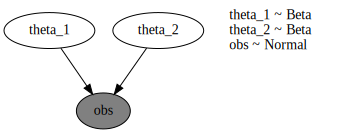

In [6]:
model_2 = model(theta1_beta, theta2_beta)
model_2(x[0],y[0])
pyro.render_model(model_2, model_args=(x[0],y[0]),render_distributions=True)

In [9]:
hmc_kernel = HMC(model=model_2) # transition kernel
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=500, num_chains=1)
mcmc.run(x,y)
print(mcmc.get_samples().keys())

Warmup:   7%|▋         | 104/1500 [00:23,  2.07it/s, step size=3.71e-05, acc. prob=0.783]

torch.Size([3, 500])
torch.Size([3, 500]) <enumerate object at 0x7eff2c5e8280>


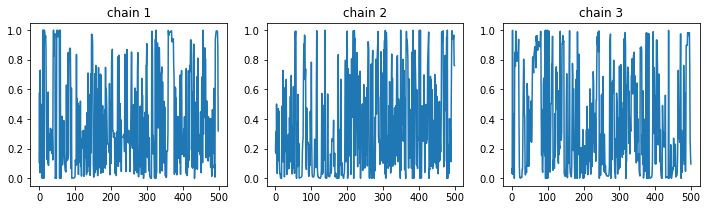

In [7]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
chains = mcmc_samples["theta_1"]
print(chains.shape)

n_chains, n_samples = chains.shape
print(chains.shape, enumerate(chains))

fig, ax = plt.subplots(1, 3, figsize=(12,3))
for i, chain in enumerate(chains):
    sns.lineplot(x=range(n_samples), y=chain, ax=ax[i])
    ax[i].set_title("chain "+str(i+1))

expected theta1 = 0.37131038308143616


/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


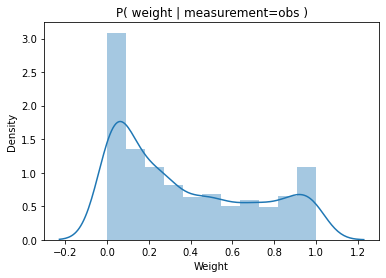

In [8]:
print("expected theta1 =", mcmc_samples['theta_1'].mean().item())

sns.distplot(mcmc_samples['theta_1'])
plt.title("P( weight | measurement=obs )")
plt.xlabel("Weight")
plt.show()